### Cloning [**simplif-ai**](https://github.com/namanshrimali/simplif-ai.git)
A library which have all the boilerplate codes available as a module, a one stop solution to jump start deep learning 

In [1]:
!git clone https://github.com/namanshrimali/simplif-ai.git
!pip install -U albumentations
%cd simplif-ai

%matplotlib inline 
# This turns on inline plotting, where plot graphics will appear in notebook.

Cloning into 'simplif-ai'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 168 (delta 63), reused 130 (delta 35), pack-reused 0
Receiving objects: 100% (168/168), 40.10 KiB | 10.03 MiB/s, done.
Resolving deltas: 100% (63/63), done.
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 952kB 26.7MB/s 
     |████████████████████████████████| 37.6MB 85kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
/content/simplif-ai


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
from util.devices import find_device
from data_action.data_loader import *
from util.mean_std_calc import calc_mean_std
from util.seed import seed_everything

seed_everything()
device = find_device()
BATCH_SIZE = 512
DATASET = 'CIFAR10' 
mean, std = (0.49139884, 0.48215783, 0.44653153), (0.20230089, 0.19941294, 0.200962)
# mean, std = calc_mean_std(DATASET) # calculates mean and standard deviation of the dataset

data_loader = Data_Loader(device, BATCH_SIZE, dataset = DATASET, mean = mean, std = std, transform_type='common')

trainloader = data_loader.load_training_data()
testloader = data_loader.load_testing_data()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

target_layers = ["layer1", "layer2", "layer3", "layer4"] # for gradcam


device: cuda

Loading training data. Dataset: CIFAR10


Extracting ../data/cifar-10-python.tar.gz to ../data
Training data loaded

Loading testing data.
Files already downloaded and verified
Test data loaded



Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


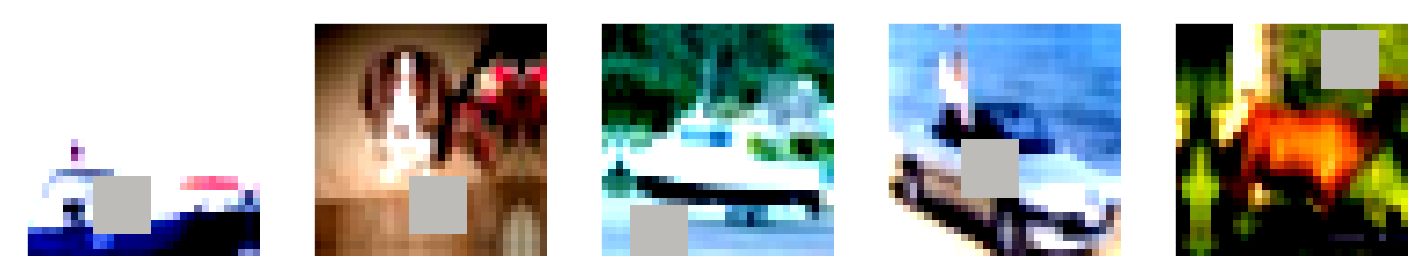

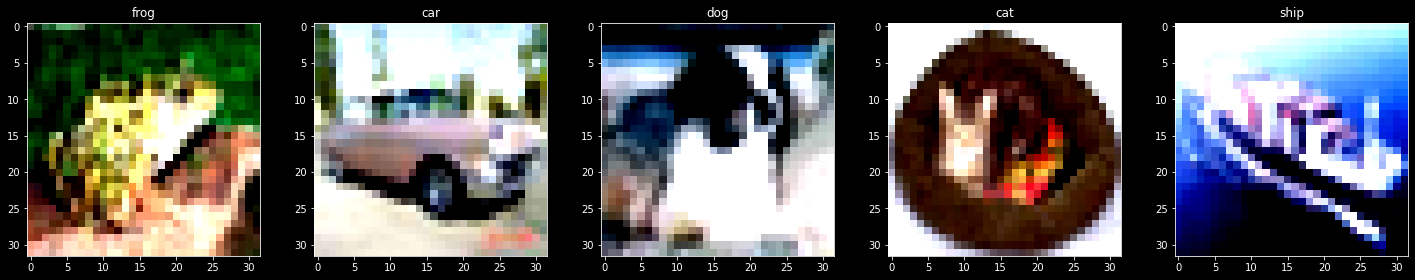

In [3]:
from util.image_plot import plot_images

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and their labels
plot_images(dataiter, classes, total=5)

# get some random testing images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images and their labels
plot_images(dataiter, classes, total=5)


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [4]:
from model.modified_resnet import ResNet18
model = ResNet18(0.0).to(device) # configuring 0% dropout in the resnet-18

### Model summary

In [5]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
          Dropout-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
          Dropout-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

## Training model
> * finding optimal learning rate
> * defining Stochastic Gradient Descent as optimizer
---





### Defining optimizer and scheduler

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn


optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

### Finding optimal learning rate


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.19E-01


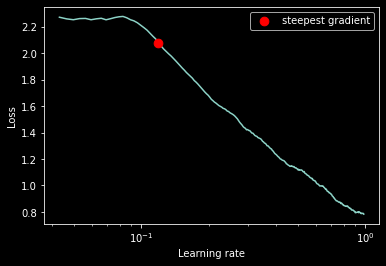

In [7]:
from analytics.lr_finder.finder_util import find_me_ideal_lr

ideal_lr = find_me_ideal_lr(model, optimizer, criterion, trainloader, device, plot_graph = True, num_iter = 300, step_mode = "linear")

### Setting optimal learning rate


In [8]:
  EPOCHS = 24
  MAX_AT_EPOCH = 5
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer= optimizer, epochs=EPOCHS, steps_per_epoch = len(trainloader), pct_start=MAX_AT_EPOCH/EPOCHS, max_lr = ideal_lr, div_factor= 8., final_div_factor=1, verbose=False)

In [9]:
from learning.train import train
from learning.validate import test

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
learning_rates = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    misclassified = []
    print(f'Epoch: {epoch+1}')
    train(model, device, trainloader, train_loss, train_accuracy, optimizer, learning_rates, scheduler)
    val_loss = test(model, device, testloader, test_loss, test_accuracy, misclassified)

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1


loss=1.1301146745681763 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


\Train set: Accuracy: 23765/50000 (47.5300%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2069, Accuracy: 5797/10000 (57.97%)

Epoch: 2


loss=0.757644772529602 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 32920/50000 (65.8400%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8595, Accuracy: 6926/10000 (69.26%)

Epoch: 3


loss=0.7292420864105225 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 36448/50000 (72.8960%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7369, Accuracy: 7514/10000 (75.14%)

Epoch: 4


loss=0.5845760107040405 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


\Train set: Accuracy: 38730/50000 (77.4600%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6899, Accuracy: 7644/10000 (76.44%)

Epoch: 5


loss=0.41515591740608215 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 40339/50000 (80.6780%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6990, Accuracy: 7869/10000 (78.69%)

Epoch: 6


loss=0.434236079454422 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 41647/50000 (83.2940%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6545, Accuracy: 7906/10000 (79.06%)

Epoch: 7


loss=0.3503214120864868 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


\Train set: Accuracy: 42869/50000 (85.7380%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4763, Accuracy: 8424/10000 (84.24%)

Epoch: 8


loss=0.4319974482059479 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


\Train set: Accuracy: 43558/50000 (87.1160%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4698, Accuracy: 8422/10000 (84.22%)

Epoch: 9


loss=0.2527521848678589 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


\Train set: Accuracy: 44274/50000 (88.5480%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4629, Accuracy: 8455/10000 (84.55%)

Epoch: 10


loss=0.3029235899448395 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 45033/50000 (90.0660%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5245, Accuracy: 8484/10000 (84.84%)

Epoch: 11


loss=0.28502681851387024 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 45461/50000 (90.9220%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4565, Accuracy: 8600/10000 (86.00%)

Epoch: 12


loss=0.1845003217458725 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


\Train set: Accuracy: 46012/50000 (92.0240%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5269, Accuracy: 8500/10000 (85.00%)

Epoch: 13


loss=0.20361021161079407 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


\Train set: Accuracy: 46588/50000 (93.1760%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4497, Accuracy: 8691/10000 (86.91%)

Epoch: 14


loss=0.2407950609922409 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 46913/50000 (93.8260%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5098, Accuracy: 8699/10000 (86.99%)

Epoch: 15


loss=0.16274583339691162 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 47186/50000 (94.3720%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5026, Accuracy: 8726/10000 (87.26%)

Epoch: 16


loss=0.16525398194789886 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]


\Train set: Accuracy: 47503/50000 (95.0060%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4167, Accuracy: 8870/10000 (88.70%)

Epoch: 17


loss=0.162922203540802 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 47796/50000 (95.5920%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4472, Accuracy: 8796/10000 (87.96%)

Epoch: 18


loss=0.08347933739423752 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 48175/50000 (96.3500%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4131, Accuracy: 8926/10000 (89.26%)

Epoch: 19


loss=0.11358033865690231 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 48520/50000 (97.0400%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4171, Accuracy: 8942/10000 (89.42%)

Epoch: 20


loss=0.09660471230745316 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 48669/50000 (97.3380%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4166, Accuracy: 9014/10000 (90.14%)

Epoch: 21


loss=0.044228289276361465 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 48918/50000 (97.8360%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4101, Accuracy: 9031/10000 (90.31%)

Epoch: 22


loss=0.05465947464108467 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 49085/50000 (98.1700%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4049, Accuracy: 9047/10000 (90.47%)

Epoch: 23


loss=0.06861195713281631 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]


\Train set: Accuracy: 49210/50000 (98.4200%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4007, Accuracy: 9077/10000 (90.77%)

Epoch: 24


loss=0.05004728585481644 batch_id=97: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]


\Train set: Accuracy: 49269/50000 (98.5380%)


Test set: Average loss: 0.4229, Accuracy: 9055/10000 (90.55%)



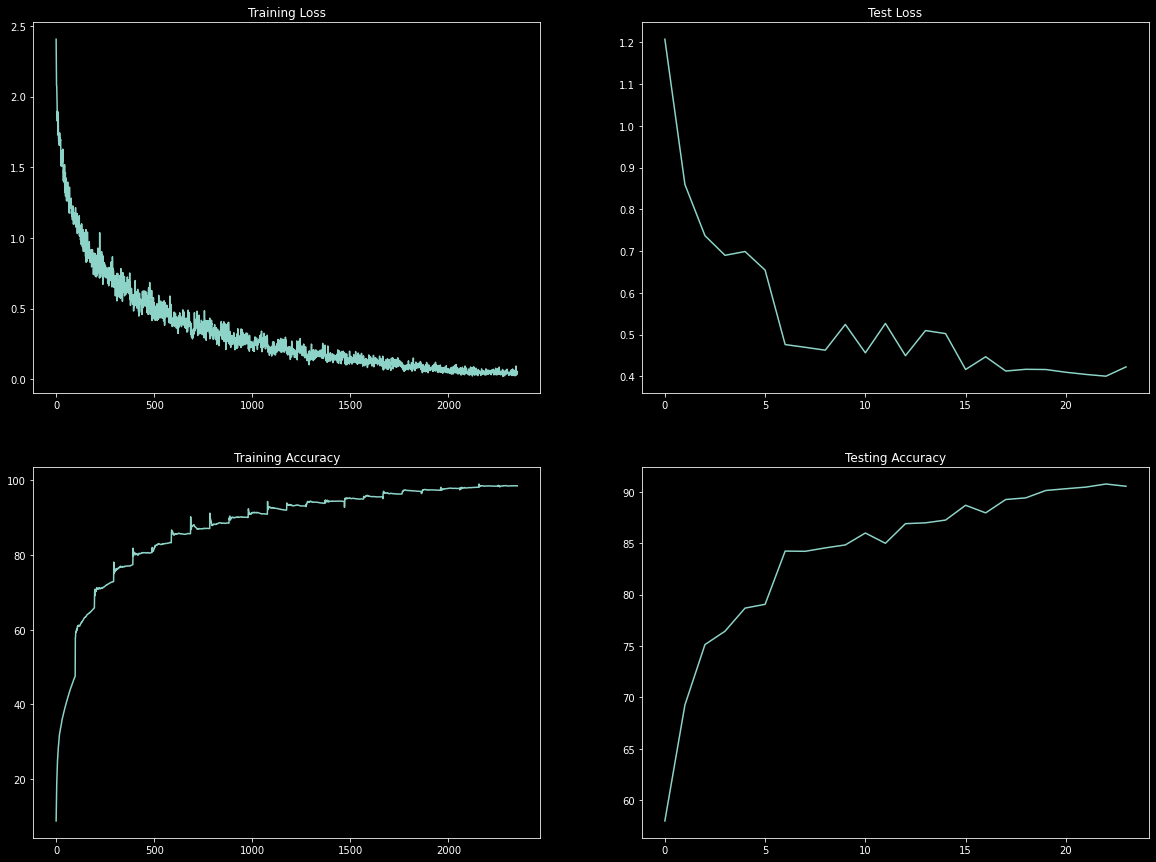

In [10]:
from util.graph_plot import plot_me
plot_me(train_loss, train_accuracy, test_loss, test_accuracy)

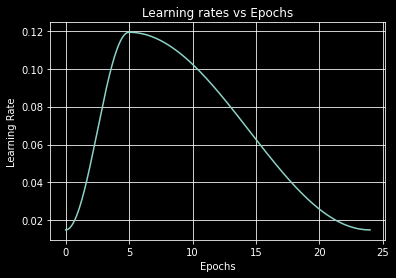

In [11]:
import numpy
from util.graph_plot import plot_graph

x_plots  = np.arange(0, EPOCHS, 1/len(trainloader))
plot_graph((x_plots, learning_rates), 'Learning rates vs Epochs', ('Epochs', 'Learning Rate'), save= True)